## Проверка системы сплитирования 

### Подключение библиотек, определение функций и забор данных

In [1]:
#подключаемся к библиотекам
import pandas as pd
import pandahouse as ph
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#забираем данные АА-теста с '2022-07-06' по '2022-07-12' из базы данных и переноим их в дата фрэйм
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20220820',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

query = '''
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-07-06' and '2022-07-12'
    and exp_group in (2,3)
GROUP BY exp_group, user_id
'''

df = ph.read_clickhouse(query, connection=connection)

In [3]:
# функция расчёта p_value для двух выборок Т-тестом

def p_test (samp1, samp2):
    p_val = stats.ttest_ind(samp1, samp2,
                equal_var=False)[1]
    return p_val

In [4]:
# функция имитации множественного повтора АА-теста, 
    # передает лист p_value для каждого из них на проверку, 
    # показывает результат проверки, возвращает лист p_value
    
def aa_test(samp1, samp2, dur = 10000):
    p_val_list = []
    
    for i in range(dur):
        sub_samp1 = samp1.sample(500, replace=False).tolist()
        sub_samp2 = samp2.sample(500, replace=False).tolist()
        
        p_val_list.append(p_test(sub_samp1, sub_samp2))
    
    res = check_aa(p_val_list, dur)
        
    return p_val_list, res

In [5]:
# функция проверки количества стат значимых результатов из общего числа

def check_aa(p_lst, number_of_repeat = 10000):
    
    cnt_p = [x for x in p_lst if x < 0.05]
    cnt_test_true = round(len(cnt_p) / number_of_repeat * 100, 4)
    
    return f'Количество стат значимых результатов из {number_of_repeat}: {cnt_test_true}% или {cnt_test_true/100 * number_of_repeat:.0f}'

In [6]:
#Разбиваем датафрейм на две группы относительно группы эксперимента

df_2, df_3 = df[df.exp_group == 2], df[df.exp_group == 3]

### Предварительный анализ

Перед проведением АВ-тестирования необходимо проверить системы сплитирования, чтобы быть уверенными в надежности полученных результатов. Для этого проводят на метрике АА-тест на двух группах из одной генеральной совокупности.

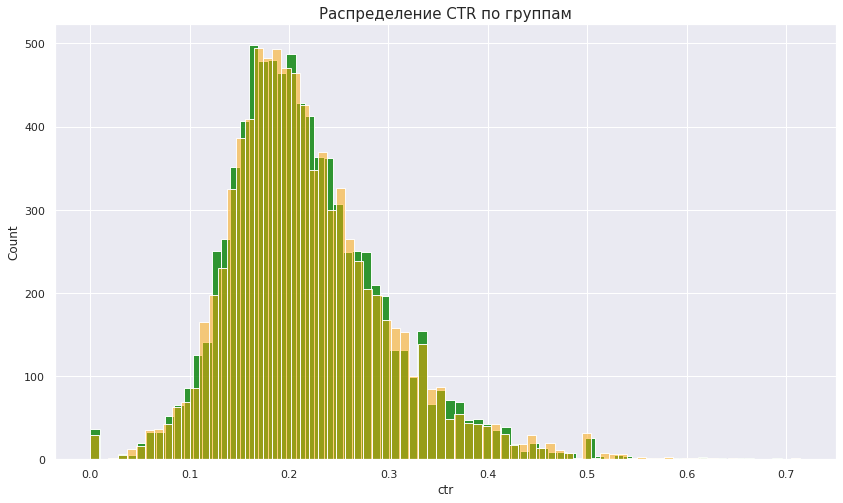

In [7]:
# Рассмотрим распределния визуально
sns.set(rc={'figure.figsize':(14,8)})

sns.histplot(df_2.ctr, color = 'green', alpha = 0.8)
sns.histplot(df_3.ctr, color = 'orange', alpha = 0.5)
plt.title('Распределение CTR по группам', size = 15)
plt.show()

Визуально распределния не отличаются, проверим это симуляцией множественных проведений АА-теста.

### АА-тесты

In [8]:
#считаем и собираем результаты АА-тестов
p_val_list, res = aa_test(df_2.ctr, df_3.ctr)

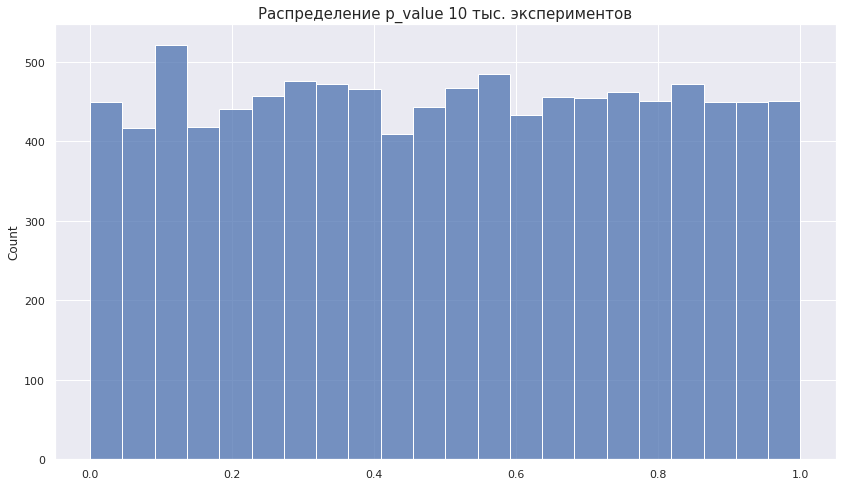

Количество стат значимых результатов из 10000: 4.86% или 486


In [9]:
#построим график

sns.histplot(p_val_list)
plt.title('Распределение p_value 10 тыс. экспериментов', size = 15)

plt.show()
print(res)
#ВОПРОС: почему при выключении вызова plt.show() остается комментарий построения?

### Результаты
P_value распределено равномерно, что соответствует ситуации истинности нулевой гипотезы - обе выборки принадлежат одному ГС.
Это подтвержается и тем, что общее количество значимых результатов меньше 5%, который соотвествует уровню значимости альфа 0,05.

*Вывод* - система сплитирования работает.